# Forecasting Hierárquico

Muitas vezes, não apenas temos múltiplas séries temporais, mas essas séries também estão organizadas em uma hierarquia. Por exemplo, vendas de produtos podem ser organizadas por SKU, categoria, departamento e total da loja.

Vamos usar o mesmo dataset sintético, mas agora com uma hierarquia de produtos.

```{mermaid}

graph TD
  root["__total"]

  %% group -1
  root --> g_minus1["-1"]
  g_minus1 --> sku20["20"]
  g_minus1 --> sku21["21"]
  g_minus1 --> sku22["22"]
  g_minus1 --> sku23["23"]
  g_minus1 --> sku24["24"]

  %% group 0
  root --> g0["0"]
  g0 --> sku0["0"]
  g0 --> sku1["1"]
  g0 --> sku2["2"]
  g0 --> sku3["3"]
  g0 --> sku4["4"]

  %% group 1
  root --> g1["..."]

  
  %% group 3
  root --> g3["3"]
  g3 --> sku15["15"]
  g3 --> sku16["16"]
  g3 --> sku17["17"]
  g3 --> sku18["18"]
  g3 --> sku19["19"]
```


Ao mesmo tempo que dados hierarárquicos são interessantes pois nos trazem mais informação, eles também trazem desafios adicionais. Imagine que queremos prever as vendas futuras de cada produto. Se fizermos previsões independetes para cada produto, não há garantia que a soma das previsões dos produtos será igual à previsão do total da loja. Isso é chamado de incoerência nas previsões hierárquicas. O processo de ajustar as previsões para garantir coerência é chamado de **reconciliação**.

## Carregando dados

Vamos usar os dados sintéticos, agora com sua versao hierárquica.

In [1]:
# | echo: false

import warnings
import pandas as pd
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
from tsbook.datasets.retail import SyntheticRetail

dataset = SyntheticRetail("hierarchical")
y_train, X_train, y_test, X_test = dataset.load("y_train", "X_train", "y_test", "X_test")

## Uso de pandas e dados hierárquicos

Agora, os dataframes possuem mais de 2 ou mais índices, representando a hierarquia.

In [3]:
y_train

sales
group_id sku_id  date             
-1       20      2020-01-01      0
                 2020-01-02      0
                 2020-01-03      0
                 2020-01-04      0
                 2020-01-05      2
...                            ...
__total  __total 2024-07-01   2000
                 2024-07-02   1616
                 2024-07-03   1917
                 2024-07-04   2384
                 2024-07-05   2462

[51088 rows x 1 columns]

Para obter o número de pontos de série únicos (séries temporais individuais), podemos fazer o seguinte:

In [4]:
y_train.index.droplevel(-1).nunique()

31

Note que existem algumas séries com um identificador `__total`. Esse identificador representa o total para aquele nível da hierarquia. Por exemplo, se o id completo é `(-1, "__total")`, isso representa o total do grupo -1.

In [5]:
y_train.loc[(-1, "__total")].head()

,sales
date,
2020-01-01,4
2020-01-02,2
2020-01-03,3
2020-01-04,14
2020-01-05,16


O total de todas as séries é representado por `("__total", "__total")`.

In [6]:
y_train.loc[("__total", "__total")]

,sales
date,
2020-01-01,24
2020-01-02,19
2020-01-03,14
2020-01-04,23
2020-01-05,23
...,...
2024-07-01,2000
2024-07-02,1616
2024-07-03,1917


Para contabilizar o número de séries temporais individuais, podemos fazer o seguinte:

In [7]:
y_train.index.droplevel(-1).nunique()

31

## Previsão sem reconciliação

Vamos fazer uma previsão e entender o problema da incoerência.

In [8]:
fh = y_test.index.get_level_values(-1).unique()

In [9]:
from tsbook.forecasting.reduction import ReductionForecaster
from lightgbm import LGBMRegressor

forecaster = ReductionForecaster(
    LGBMRegressor(n_estimators=100, verbose=-1, objective="tweedie", random_state=42),
    window_length=30,
    normalization_strategy="divide_mean",
)
forecaster.fit(y_train, X=X_train)
y_pred = forecaster.predict(fh, X=X_test)

Para somar as previsões de baixo para cima, podemos usar o transformador `Aggregator`. Vamos ver que,
quando somarmos as previsões das séries filhas, o resultado não é igual à previsão da série total.

In [10]:
from sktime.transformations.hierarchical.aggregate import Aggregator

Aggregator().fit_transform(y_pred) - y_pred

sales
group_id sku_id  date                  
-1       20      2024-07-06    0.000000
                 2024-07-07    0.000000
                 2024-07-08    0.000000
                 2024-07-09    0.000000
                 2024-07-10    0.000000
...                                 ...
__total  __total 2024-12-28   55.335283
                 2024-12-29  156.831394
                 2024-12-30  210.198180
                 2024-12-31  190.297510
                 2025-01-01   13.594787

[5580 rows x 1 columns]

Existe uma diferença... ou seja, os valores não batem.
Imagine o impacto de levar previsões incoerentes para a tomada de decisão em uma empresa?
A raiz do problema é que temos mais modelos que graus de liberdade. Para ilustrar, suponha que temos 3 séries: $A$, $B$ e $C$, onde:

$$
C(t) = A(t) + B(t)
$$

Aqui, temos 3 séries, mas apenas 2 graus de liberdade, pois $C$ é completamente determinado por $A$ e $B$. Se fizermos previsões independentes para $A$, $B$ e $C$, não há garantia de que a relação acima será mantida nas previsões.

## Reconciliação de previsões hierárquicas

![](img/hierarchical_reconciled_vs_not.png)

Existem diferentes métodos para reconciliar previsões em séries temporais hierárquicas. Não existe uma solução única, e o melhor método depende dos dados e do contexto.

## Bottom-up

A maneira mais simples de reconcialiar previsões hierárquicas é a abordagem **bottom-up**. Nessa abordagem, fazemos previsões apenas para as séries mais baixas na hierarquia (as séries filhas) e depois somamos essas previsões para obter as previsões das séries superiores (as séries pais).

<img src="img/hierarchical_bottomup.png" alt="Hierarchical Bottom-up" width="450">

Lados positivos:

* Simplicidade: fácil de entender e implementar.
* Coerência garantida: a soma das previsões das séries filhas sempre será igual à previsão da série pai.
* Sérias filhas podem capturar detalhes específicos que podem ser perdidos em níveis superiores.

No entanto, essa abordagem também tem desvantagens: é sucetível ao ruído nas séries filhas, e se as séries filhas tiverem pouca informação, as previsões podem ser ruins. Por exemplo, muitos zeros nas séries de níveis baixos pode levar a previsões ruins a niveis agregados.

In [11]:
from sktime.transformations.hierarchical.reconcile import BottomUpReconciler

bottom_up = BottomUpReconciler() * forecaster
bottom_up.fit(y_train)

y_pred_bottomup = bottom_up.predict(fh=fh)

Agora vemos que as previsões são coerentes:

In [12]:
Aggregator().fit_transform(y_pred_bottomup) - y_pred_bottomup

sales
group_id sku_id  date             
-1       20      2024-07-06    0.0
                 2024-07-07    0.0
                 2024-07-08    0.0
                 2024-07-09    0.0
                 2024-07-10    0.0
...                            ...
__total  __total 2024-12-28    0.0
                 2024-12-29    0.0
                 2024-12-30    0.0
                 2024-12-31    0.0
                 2025-01-01    0.0

[5580 rows x 1 columns]

## Top-down (forecast proportions)

Outra abordagem é a **top-down**. Nessa abordagem, fazemos previsões apenas para as séries superiores na hierarquia (as séries pais) e depois distribuímos essas previsões para as séries filhas com base em proporções previstas.

Suponha que temos a seguinte hierarquia $C(t) = A(t) + B(t)$. Considere $\hat{C}(t)$, $\hat{A}(t)$ e $\hat{B}(t)$ como as previsões para $C$, $A$ e $B$, respectivamente. Na abordagem top-down, faríamos o seguinte:

1. Prever $\hat{C}(t)$, $\hat{A}(t)$ e $\hat{B}(t)$ independentemente.
2. Calcular as proporções previstas para os níveis mais baixos:
$$
p_A(t) = \frac{\hat{A}(t)}{\hat{A}(t) + \hat{B}(t)}
$$

$$
p_B(t) = \frac{\hat{B}(t)}{\hat{A}(t) + \hat{B}(t)}
$$

3. Distribuir a previsão de $C$ para $A$ e $B$ usando essas proporções:
$$
\tilde{A}(t) = p_A(t) \cdot \hat{C}(t)
$$

$$
\tilde{B}(t) = p_B(t) \cdot \hat{C}(t)
$$

Essa abordagem é capaz de usufruir da qualidade do forecast total, e ainda consegue distribuir para as séries filhas baseadas no histórico.

<img src="img/hierarchical_td_fcst.png" alt="Topdown Forecast" width="900">


O que chamam de "Proporções históricas" é equivalente a esse método, mas com um modelo Naive para prever as proporções.

Esse método pode ser bom quando o forecast total é de boa qualidade. No entanto,
dependemos profundamente da qualidade do forecast total e das proporções.

In [13]:
from sktime.transformations.hierarchical.reconcile import TopdownReconciler

top_down_fcst = TopdownReconciler() * forecaster
top_down_fcst.fit(y_train)

y_pred_topdown = top_down_fcst.predict(fh=fh)

## Reconciliação ótima

Existe uma abordagem mais sofisticada, com uma intuição geométrica interessante.
A ideia é ajustar as previsões iniciais para que elas satisfaçam as restrições de soma da hierarquia. Por exemplo, para a hierarquia $C(t) = A(t) + B(t)$, queremos garantir que:

$$
\hat{C}(t) = \hat{A}(t) + \hat{B}(t)
$$

Se consideramos nosso espaço 3D de observações $(\hat{A}, \hat{B}, \hat{C})$, a 
condição acima é satisfeita para um plano 2D nesse universo.


![](img/coherent_plane.png)


Podemos então projetar nossas previsões iniciais nesse plano para obter previsões coerentes. Essa projeção pode ser feita de várias maneiras, levando a diferentes métodos de reconciliação ótima. Os métodos levam o nome "OLS" pois a projeção é feita minimizando o erro quadrático (Ordinary Least Squares).

* **OLS** : projetar ortogonalmente todas as previsões base na espaço de reconciliação, tratando todas as séries igualmente.
* **Weighted OLS**: projetar obliquamente, ou seja, considerando pesos diferentes para cada série, permitindo dar mais importância a certas séries na reconciliação. A projeção não faz mais uma perpendicular, mas sim uma oblíqua.
* **Minimum trace (MinT)**: use a matriz de covariância do erro para encontrar as previsões reconciliadas ótimas. Chamado de "ótimo".


Para a reconciliação ótima com OLS, podemos usar o `OptimalReconciler` do sktime:

In [14]:
from sktime.transformations.hierarchical.reconcile import OptimalReconciler

optimal = OptimalReconciler("ols") * forecaster
optimal.fit(y_train)
y_pred_optimal = optimal.predict(fh=fh)

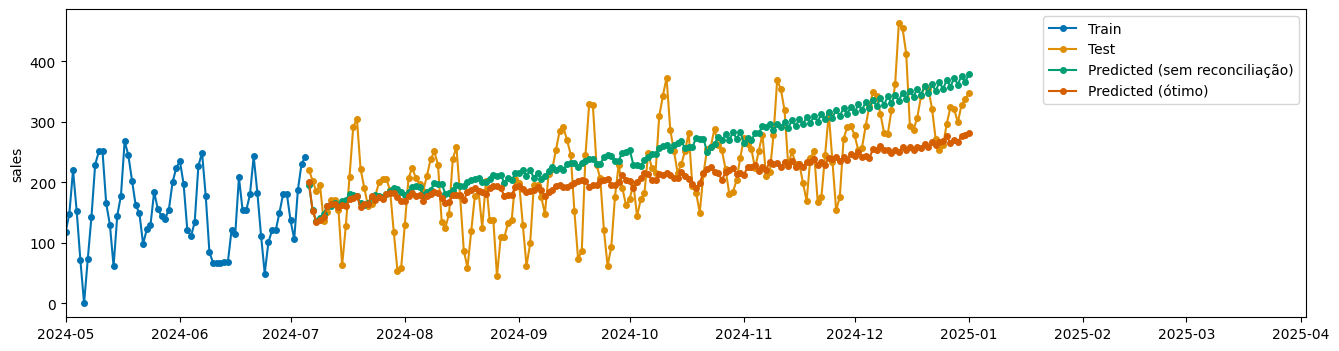

In [15]:
# | code-fold: true
from sktime.utils.plotting import plot_series
import matplotlib.pyplot as plt
import pandas as pd


idx = y_train.index.droplevel(-1).unique()[10]

plot_series(
    y_train.loc[idx,],
    y_test.loc[idx,],
    y_pred.loc[idx,],
    y_pred_optimal.loc[idx,],
    labels=["Train", "Test", "Predicted (sem reconciliação)", "Predicted (ótimo)"],
)
plt.xlim(pd.to_datetime("2024-05-01"), None)
plt.show()

Para reconciliações ótimas (que usam a covariância do erro), podemos usar o `ReconcilerForecaster` do sktime, que internamente já faz o cálculo da covariância do erro:

In [16]:
from sktime.forecasting.reconcile import ReconcilerForecaster


mint_forecaster = ReconcilerForecaster(
    forecaster=forecaster,
    method="mint_shrink")

mint_forecaster.fit(y_train)
y_pred_mint = mint_forecaster.predict(fh=fh)

## Comparando resultados

In [17]:
from sktime.performance_metrics.forecasting import MeanSquaredScaledError

metric = MeanSquaredScaledError(multilevel="uniform_average_time")

pd.DataFrame(
    {
        "Baseline": metric(y_test, y_pred, y_train=y_train),
        "BottomUpReconciler": metric(y_test, y_pred_bottomup, y_train=y_train),
        "TopDownReconciler": metric(y_test, y_pred_topdown, y_train=y_train),
        "OptimalReconciler (ols)": metric(y_test, y_pred_optimal, y_train=y_train),
        "Mint Reconciler": metric(y_test, y_pred_mint, y_train=y_train),
    },
    index=["Mean Absolute Squared Error"],
)

,Baseline,BottomUpReconciler,TopDownReconciler,OptimalReconciler (ols),Mint Reconciler
Mean Absolute Squared Error,40.179149,26.079303,90.661393,59.86903,22.794349
